Dengue fever is bad. It's real bad. Dengue is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash and muscle and joint pain. But severe cases are dangerous, and dengue fever can cause severe bleeding, low blood pressure and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

We've [launched a competition](https://www.drivendata.org/competitions/44/) to use open data to predict the occurrence of Dengue based on climatological data. Here's a first look at the data and how to get started!

As always, we begin with the sacred `import`'s of data science:

In [2]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

## A Tale of Two Cities

![](https://community.drivendata.org/uploads/default/original/1X/4c3a8204d1715b5e2ee24da78abbad1515eccd5f.png)

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train seperate models for each city, and then join our predictions before making our final submission.

In [3]:
# load the provided data
train_features = pd.read_csv('../data/01_raw/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('../data/01_raw/dengue_labels_train.csv',
                           index_col=[0,1,2])

In [4]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [35]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:                    ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
year weekofyear                                                                 
1990 18          0.122600  0.103725  0.198483  0.177617                 12.42   
     19          0.169900  0.142175  0.162357  0.155486                 22.82   
     20          0.032250  0.172967  0.157200  0.170843                 34.54   
     21          0.128633  0.245067  0.227557  0.235886                 15.36   
     22          0.196200  0.262200  0.251200  0.247340                  7.52   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
year weekofyear                                                 
1990 18                     297.572857             297.742857   
     19                     298.211429             298.442857   
     20                     298.781429             298.878571   
     21                     298.987143             299.228571   
     22               

The [problem description](https://www.drivendata.org/competitions/44/page/82/) gives a good overview of the available variables, but we'll look at the head of the data here as well:

In [36]:
sj_train_features.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
year weekofyear                                                                 
1990 18          0.122600  0.103725  0.198483  0.177617                 12.42   
     19          0.169900  0.142175  0.162357  0.155486                 22.82   
     20          0.032250  0.172967  0.157200  0.170843                 34.54   
     21          0.128633  0.245067  0.227557  0.235886                 15.36   
     22          0.196200  0.262200  0.251200  0.247340                  7.52   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
year weekofyear                                                 
1990 18                     297.572857             297.742857   
     19                     298.211429             298.442857   
     20                     298.781429             298.878571   
     21                     298.987143             299.228571   
     22                     299.518571             299.664286   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
year weekofyear                                                           
1990 18                           292.414286                      299.8   
     19                           293.951429                      300.9   
     20                           295.434286                      300.5   
     21                           295.310000                      301.4   
     22                           295.821429                      301.9   

                 reanalysis_min_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              295.9  ...   
     19                              296.4  ...   
     20                              297.3  ...   
     21                              297.0  ...   
     22                              297.5  ...   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
year weekofyear                                                              
1990 18                        29.4                20.0               16.0   
     19                        31.7                22.2                8.6   
     20                        32.2                22.8          

There are _a lot_ of climate variables here, but the first thing that we'll note is that the `week_start_date` is included in the feature set. This makes it easier for competitors to create time based features, but for this first-pass model, we'll drop that column since we shouldn't use it as a feature in our model.

In [37]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

KeyError: "['week_start_date'] not found in axis"

Next, let's check to see if we are missing any values in this dataset:

In [ ]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Text(0.5, 0, 'Time')

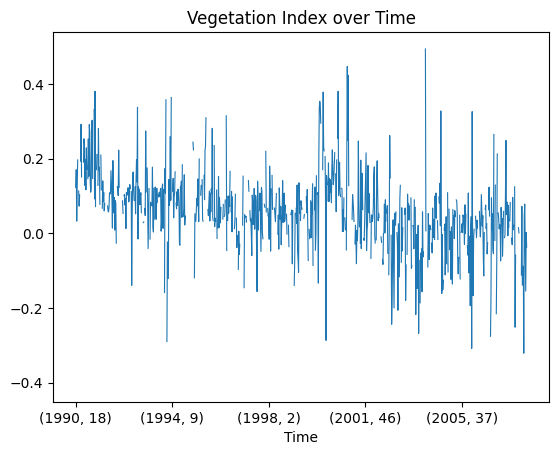

In [ ]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Since these are time-series, we can see the gaps where there are `NaN`s by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. This is probably a good part of the problem to improve your score by getting smarter.

In [ ]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

## Distribution of labels

Our target variable, `total_cases` is a non-negative integer, which means we're looking to make some **count predictions**. Standard regression techniques for this type of prediction include

1. Poisson regression
2. Negative binomial regression

Which techniqe will perform better depends on many things, but the choice between Poisson regression and negative binomial regression is pretty straightforward. Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. Why? It isn't magic. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. In fact, from this perspective, the Poisson distribution is but a special case of the negative binomial distribution.

Let's see how our labels are distributed!

In [ ]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


It's looking like a negative-binomial sort of day in these parts.

array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

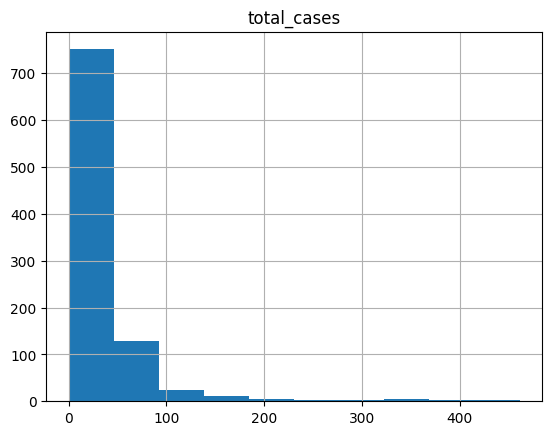

In [ ]:
sj_train_labels.hist()

array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

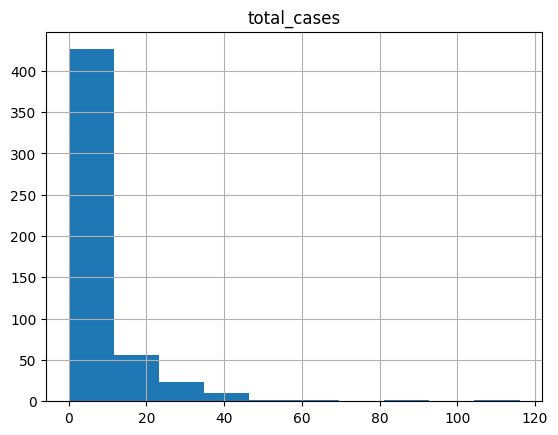

In [ ]:
iq_train_labels.hist()

### `variance  >>  mean` suggests `total_cases` can be described by a negative binomial distribution, so we'll use a negative binomial regression below.

## Which inputs strongly correlate with `total_cases`?

Our next step in this process will be to select a subset of features to include in our regression. Our primary purpose here is to get a better understanding of the problem domain rather than eke out the last possible bit of predictive accuracy. The first thing we will do is to add the `total_cases` to our dataframe, and then look at the correlation of that variable with the climate variables.

In [ ]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

Compute the data correlation matrix.

In [ ]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

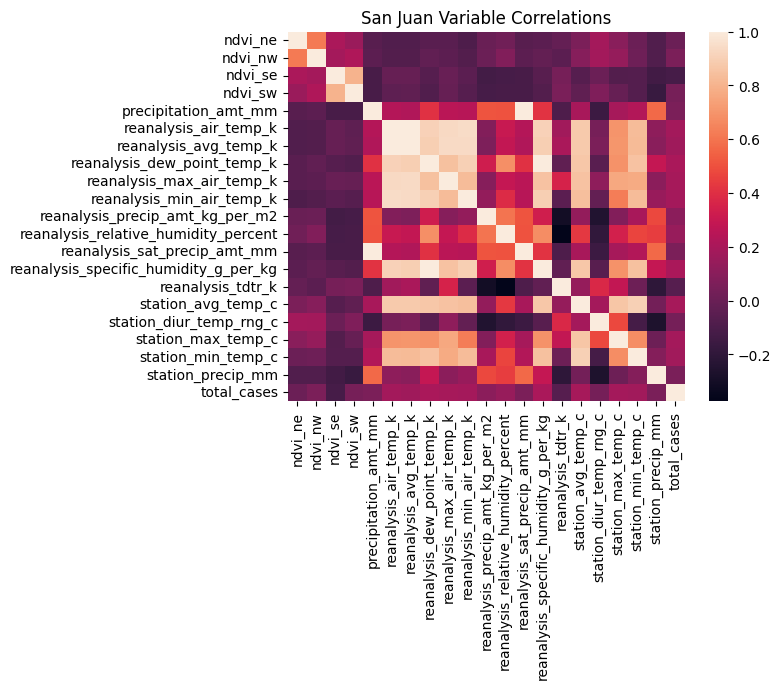

In [ ]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

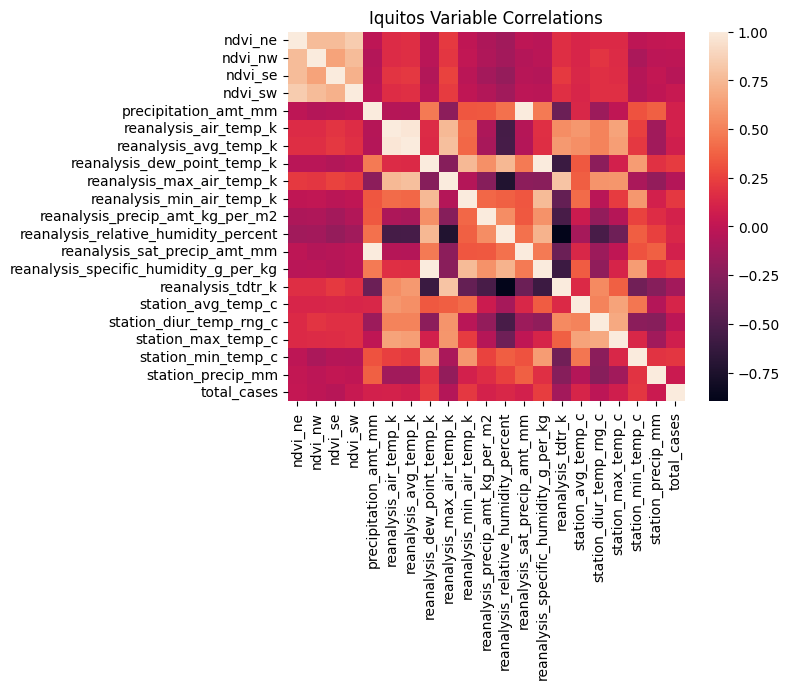

In [ ]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

### Many of the temperature data are strongly correlated, which is expected. But the `total_cases` variable doesn't have many obvious strong correlations.

Interestingly, `total_cases` seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. These correlations may give us some hints as to how to improve our model that we'll talk about later in this post. For now, let's take a `sorted` look at `total_cases` correlations.

<Axes: >

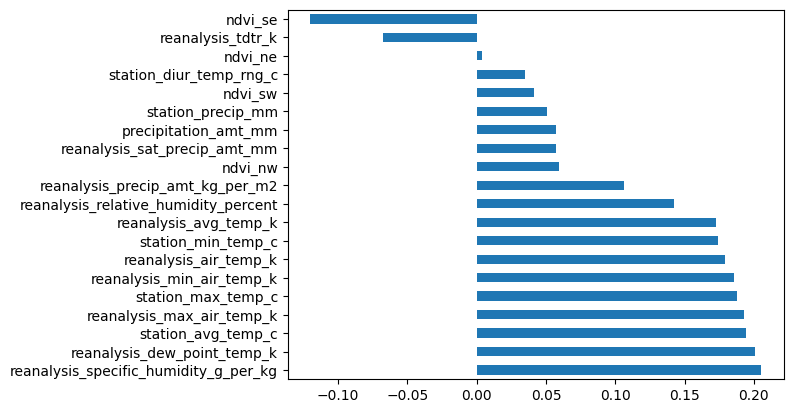

In [ ]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

<Axes: >

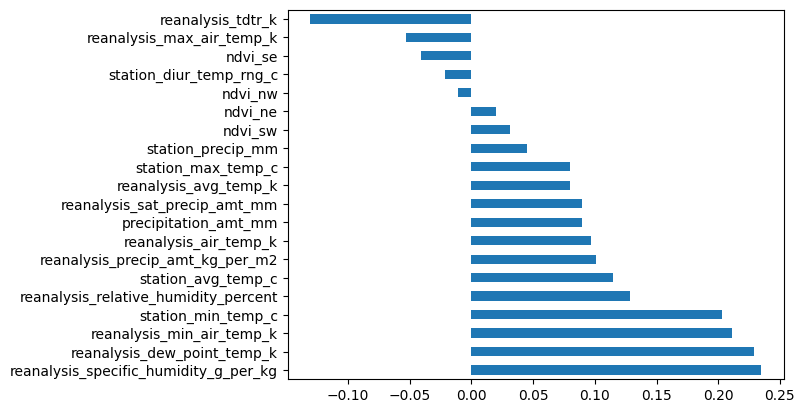

In [ ]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

### A few observations

#### The wetter the better
* The correlation strengths differ for each city, but it looks like `reanalysis_specific_humidity_g_per_kg` and `reanalysis_dew_point_temp_k` are the most strongly correlated with `total_cases`. This makes sense: we know mosquitos thrive _wet_ climates, the wetter the better!

#### Hot and heavy
* As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the `total_cases` of dengue fever tend to rise as well.

#### Sometimes it rains, so what
* Interestingly, the `precipitation` measurements bear little to no correlation to `total_cases`, despite strong correlations to the `humidity` measurements, as evident by the heatmaps above.

### This is just a first pass

Precisely _none_ of these correlations are very strong. Of course, that doesn't mean that some **feature engineering wizardry** can't put us in a better place **(`standing_water` estimate, anyone?)**. Also, it's always useful to keep in mind that **life isn't linear**, but out-of-the-box correlation measurement is – or at least, it measures linear dependence.

Nevertheless, for this benchmark we'll focus on the linear __wetness__ trend we see above, and reduce our inputs to 

#### A few good variables

* `reanalysis_specific_humidity_g_per_kg`
* `reanalysis_dew_point_temp_k`
* `station_avg_temp_c`
* `station_min_temp_c`

## A mosquito model

Now that we've explored this data, it's time to start modeling. Our first step will be to build a function that does all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.

In [ ]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [ ]:
sj_train, iq_train = preprocess_data('../data/01_raw/dengue_features_train.csv',
                                    labels_path="../data/01_raw/dengue_labels_train.csv")

Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [ ]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [ ]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


## Split it up!

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [ ]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

## Training time

This is where we start getting down to business. As we noted above, we'll train a NegativeBinomial model, which is often used for count data where the mean and the variance are very different. In this function we have three steps. The first is to specify the functional form 

In [ ]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.080882352941178
best alpha =  1e-08
best score =  6.466666666666667


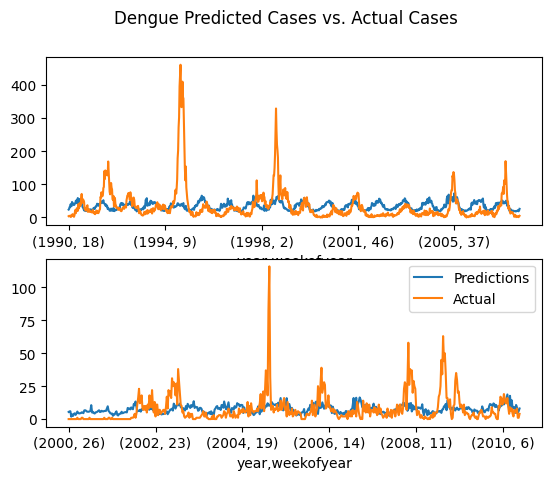

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Reflecting on our performance

These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. For example, we see that our model in blue does track the seasonality of Dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

So, we know we're not going to win this thing, but let's submit the model anyway!

In [ ]:
sj_test, iq_test = preprocess_data('../data/01_raw/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("../data/01_raw/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("../data/01_raw/benchmark.csv")

In [ ]:
# Python program for calculating Mean Absolute 
# Error using sklearn 
  
# import the module 
from sklearn.metrics import mean_absolute_error as mae 

predicted_sj = sj_best_model.fittedvalues
actual_sj = sj_train.total_cases

# calculate MAE 
error = mae(actual_sj, predicted_sj)
print("Mean absolute error : " + str(error)) 

# plot iq
predicted_iq = iq_best_model.fittedvalues
actual_iq = iq_train.total_cases

# calculate MAE 
error = mae(actual_iq, predicted_iq)
print("Mean absolute error : " + str(error))

# calculate total MAE 
error = mae(np.concatenate([actual_sj, actual_iq]),np.concatenate([predicted_sj,predicted_iq]))
print("Mean absolute error : " + str(error))




Mean absolute error : 27.11495129336763
Mean absolute error : 6.3697801318060785
Mean absolute error : 19.705961592809935


![](https://community.drivendata.org/uploads/default/original/1X/7af03e4997e8487057a77f9022691b9e9cb525f7.png)

Alright, it's a start! To build your own model you can grab this notebook [from our benchmarks repo](https://github.com/drivendata/benchmarks).

Good luck, and enjoy!